# Illustrations for publication

In [1]:
import os
import pickle
import warnings

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import pints
import seaborn as sns
sns.set_theme()

from model import define_hamberg_model, define_hamberg_population_model

## Illustrate treatment response predictions for different dosing regimens

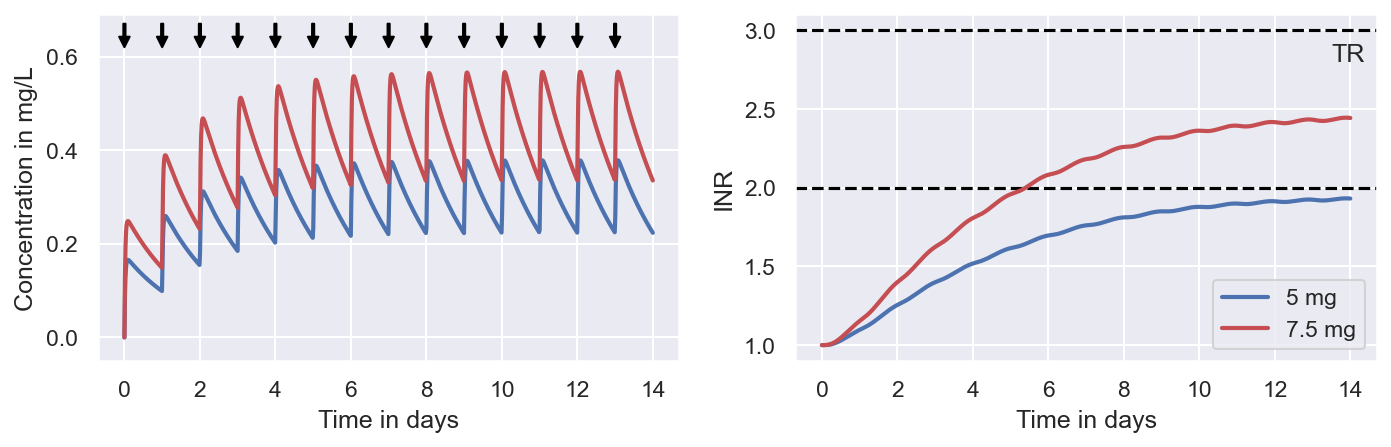

In [3]:
# Define model
model, parameters_df = define_hamberg_model()
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in model.parameters()
])

# Predict response for two dosing regimens
days = 14
times = np.linspace(0, days, num=1000) * 24
model.set_dosing_regimen(dose=5, period=24)
response1 = model.simulate(parameters=parameters, times=times)

model.set_dosing_regimen(dose=7.5, period=24)
response2 = model.simulate(parameters=parameters, times=times)

# Visualise response
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot concentration
axes[0].plot(times / 24, response1[0], label='5 mg', linewidth=2)
axes[0].plot(
    times / 24, response2[0], label='7.5 mg', color=sns.color_palette()[3],
    linewidth=2)

# Visualise therapeutic range
axes[1].axhline(y=2, color='black', linestyle='dashed')
axes[1].axhline(y=3, color='black', linestyle='dashed')

# Plot INR
axes[1].plot(times / 24, response1[1], label='5 mg', linewidth=2)
axes[1].plot(
    times / 24, response2[1], label='7.5 mg', color=sns.color_palette()[3],
    linewidth=2)

# Visualise dose points
for day in range(days):
    axes[0].annotate(
        "", xy=(day, 0.62), xytext=(day, 0.67),
        arrowprops=dict(
            width=1, headwidth=5, headlength=5, color='black'))

# Labelling
axes[0].set_ylabel('Concentration in mg/L')
axes[0].set_xlabel('Time in days')
axes[0].set_ylim([-0.05, 0.69])
axes[1].set_ylabel('INR')
axes[1].set_xlabel('Time in days')
axes[1].annotate("TR", xy=(13.5, 2.8), xytext=(13.5, 2.8))
axes[1].legend()

plt.savefig('1_illustration_pkpd_modelling.pdf', bbox_inches='tight')
plt.savefig('1_illustration_pkpd_modelling.tif', bbox_inches='tight')

plt.show()

## Illustration of optimal dosing regimen

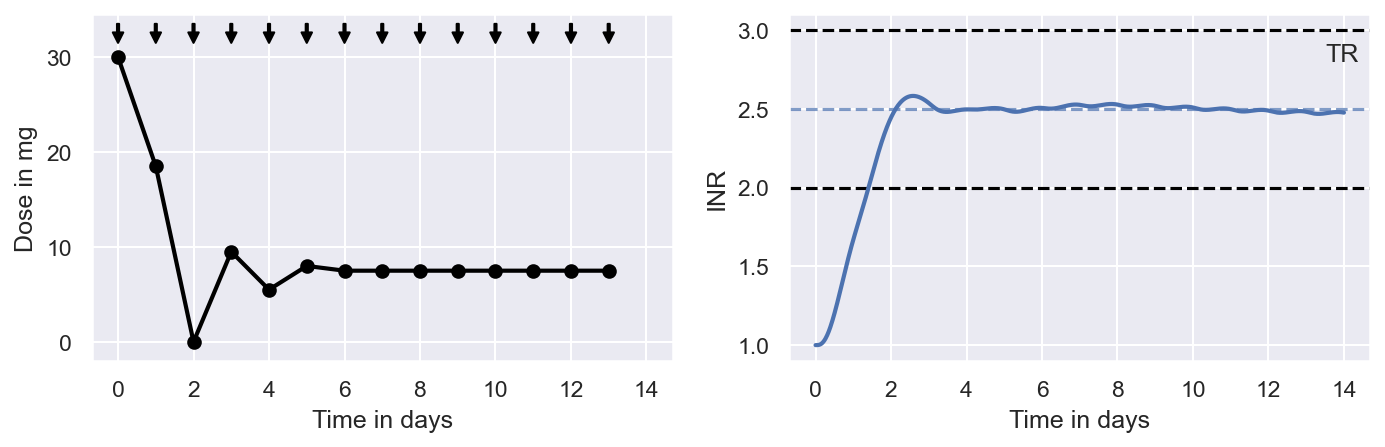

In [4]:
class SquaredINRDistance(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure based on the squared distance between a
    patient's INR and a target INR.

    :param model: Model of the patient's INR response.
    :param target: Target INR at all times.
    :param days: Number of treatment days during which the squared distance is
        computed.
    :param res: Time steps in which the INR is evaluated against the target
        in days.
    """
    def __init__(self, model, parameters, target=2.5, days=19, res=0.1):
        super(SquaredINRDistance, self).__init__()
        if model.n_parameters() != len(parameters):
            raise ValueError('Invalid model or parameters.')
        self._model = model
        self._parameters = parameters
        self._target = target
        self._doses = [0] * days
        self._duration = 0.01
        self._n_doses = 7  # After one week the maintenance dose is used

        # Construct simulation times in hours
        self._times = np.arange(0, days, res) * 24

    def __call__(self, parameters):
        # Simulate INRs for given dosing regimen
        regimen = self._define_regimen(parameters)
        self._model.set_dosing_regimen(regimen)
        try:
            inrs = self._model.simulate(
                parameters=self._parameters, times=self._times)
        except (myokit.SimulationError, Exception) as e:  # pragma: no cover
            warnings.warn(
                'An error occured while solving the mechanistic model: \n'
                + str(e) + '.\n A score of -infinity is returned.',
                RuntimeWarning)
            return np.infty

        # Compute normalised squared distance to target
        squared_distance = np.mean((inrs - self._target)**2)

        return squared_distance

    def _convert_to_tablets(self, dose):
        """
        The model accepts any dose values, but in practice we can only
        administer tablets.

        Available tablets are:

        - 1 mg
        - 2 mg
        - 2.5 mg
        - 3 mg
        - 4 mg
        - 5 mg
        - 6 mg
        - 7.5 mg
        - 10 mg

        As a result, we define the following conversion:
            1. If dose is < 0.5: 0mg
            2. If dose is >= 0.5 and < 1.5: 1mg
            3. If dose is >= 1.5 and < 2.25: 2mg
            4. If dose is >= 2.25 and < 2.75: 2.5mg
            5. Remaining doses are rounded to next half mg dose.
        """
        if dose < 0.5:
            return 0
        elif dose < 1.5:
            return 1
        elif dose < 2.25:
            return 2
        else:
            return np.round(2 * dose) / 2

    def _define_regimen(self, doses):
        if len(doses) != self._n_doses:
            raise ValueError('Invalid parameters.')
        doses = [self._convert_to_tablets(d) for d in doses]
        doses = doses[:6] + [doses[6]] * 13
        dose_rates = np.array(doses) / self._duration

        regimen = myokit.Protocol()
        for idx, dr in enumerate(dose_rates):
            if dr == 0:
                continue
            regimen.add(myokit.ProtocolEvent(
                level=dr,
                start=idx*24,
                duration=self._duration))
        self._doses = doses

        return regimen

    def n_parameters(self):
        return self._n_doses

# Define objective function
model.set_outputs(['myokit.inr'])
objective_function = SquaredINRDistance(
    model, parameters, target=2.5, days=19, res=0.1)

n_parameters = objective_function.n_parameters()
controller = pints.OptimisationController(
    objective_function,
    x0=np.ones(n_parameters),
    boundaries=pints.RectangularBoundaries(
        lower=[0]*7, upper=[30.1]*7),
    method=pints.CMAES)
controller.set_log_to_screen(False)

p, _ = controller.run()

# Format doses to daily doses
days = 14
doses = list(p)
doses = doses[:6] + [doses[6]] * (days - 6)
doses = [objective_function._convert_to_tablets(d) for d in doses]

# Predict dose response
duration = 0.01
regimen = myokit.Protocol()
dose_rates = np.array(doses) / duration
times = np.linspace(0, days, num=1000) * 24
for day, dr in enumerate(dose_rates):
    if dr == 0:
        continue
    regimen.add(myokit.ProtocolEvent(
        level=dr,
        start=day*24,
        duration=duration))
model.set_dosing_regimen(regimen)
response = model.simulate(parameters=parameters, times=times)

# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

axes[0].sharex(axes[1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot dosing regimen
axes[0].plot(np.arange(days), doses, linewidth=2, marker='o', color='black')

# Visualise therapeutic range
axes[1].axhline(y=2, color='black', linestyle='dashed')
axes[1].axhline(y=3, color='black', linestyle='dashed')

# Visualise target
axes[1].axhline(
    y=2.5, color=sns.color_palette()[0], linestyle='dashed', alpha=0.7)

# Plot INR
axes[1].plot(times / 24, response[0], linewidth=2)

# Visualise dose points
for day in range(days):
    axes[0].annotate(
        "", xy=(day, 31.5), xytext=(day, 33.5),
        arrowprops=dict(
            width=1, headwidth=5, headlength=5, color='black'))

# Labelling
axes[0].set_ylabel('Dose in mg')
axes[0].set_xlabel('Time in days')
axes[0].set_ylim([-2, 34.5])
axes[1].set_ylabel('INR')
axes[1].set_xlabel('Time in days')
axes[1].annotate("TR", xy=(13.5, 2.8), xytext=(13.5, 2.8))

plt.savefig('2_illustration_optimal_dosing_regimen.pdf', bbox_inches='tight')
plt.savefig('2_illustration_optimal_dosing_regimen.tif', bbox_inches='tight')

plt.show()

## Illustrate treatment response variability

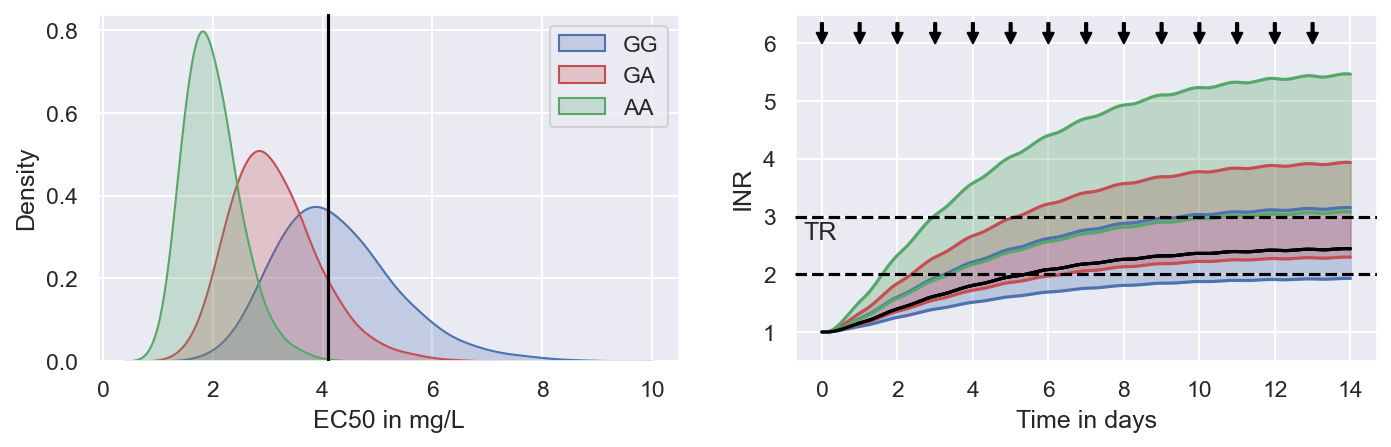

In [5]:
# Define model
model, parameters_df = define_hamberg_model()
population_model = define_hamberg_population_model(conc=False)
pop_parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])

# Sample population (only EC50 varies for simplicity)
seed = 1
n_ids = 1000
covariates = np.zeros(shape=(n_ids, 3))
covariates[:, 1] = 70
psis = np.empty(shape=(3, n_ids, 5))
for vkorc1 in [0, 1, 2]:
    covariates[:, 2] = vkorc1
    psis[vkorc1] = population_model.sample(
        pop_parameters, covariates=covariates, seed=seed, n_samples=n_ids
        )[:, :-1]
psis[:, :, 0] = parameters[0]
psis[:, :, 2:] = parameters[np.newaxis, np.newaxis, 2:]

# Predict response
days = 14
times = np.linspace(0, days, num=1000) * 24
model.set_dosing_regimen(dose=7.5, period=24)
inrs = np.empty(shape=(len(psis), n_ids, len(times)))
for idx, psi in enumerate(psis):
    for ids, sample in enumerate(psi):
        inrs[idx, ids] = model.simulate(parameters=sample, times=times)[1]

# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot VKORC distributions
labels = ['GG', 'GA', 'AA']
colors = [
    sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2]]
for idc, c in enumerate(colors):
    sns.kdeplot(
        psis[idc][:, 1], color=c, ax=axes[0], fill=True, bw_adjust=1.5,
        label=labels[idc])

# Plot individual
axes[0].axvline(x=parameters[1], color='black', zorder=100)

# Visualise therapeutic range
axes[1].axhline(y=2, color='black', linestyle='dashed', zorder=100)
axes[1].axhline(y=3, color='black', linestyle='dashed', zorder=100)

# Plot INR
for idc, c in enumerate(colors):
    fifth_percentile = np.percentile(inrs[idc], q=5, axis=0)
    ninetyfifth_percentile = np.percentile(inrs[idc], q=95, axis=0)
    axes[1].plot(
        times / 24, fifth_percentile, color=c, label=labels[idc])
    axes[1].plot(
        times / 24, ninetyfifth_percentile, color=c)
    axes[1].fill_between(
        times / 24, fifth_percentile, ninetyfifth_percentile,
        color=c, alpha=0.3)
    axes[1].plot(times / 24, response2[1], color='black')

# Visualise dose points
for day in range(days):
    axes[1].annotate(
        "", xy=(day, 6), xytext=(day, 6.35),
        arrowprops=dict(
            width=1, headwidth=5, headlength=5, color='black'))

# Labelling
axes[0].set_xlabel('EC50 in mg/L')
axes[1].set_ylabel('INR')
axes[1].set_xlabel('Time in days')
axes[1].set_ylim([0.5, 6.5])
axes[1].annotate("TR", xy=(-0.5, 2.6), xytext=(-0.5, 2.6))
axes[0].legend()

plt.savefig('3_illustration_NLME_modelling.pdf', bbox_inches='tight')
plt.savefig('3_illustration_NLME_modelling.tif', bbox_inches='tight')

plt.show()

## Illustrate variability in optimal dosing regimen

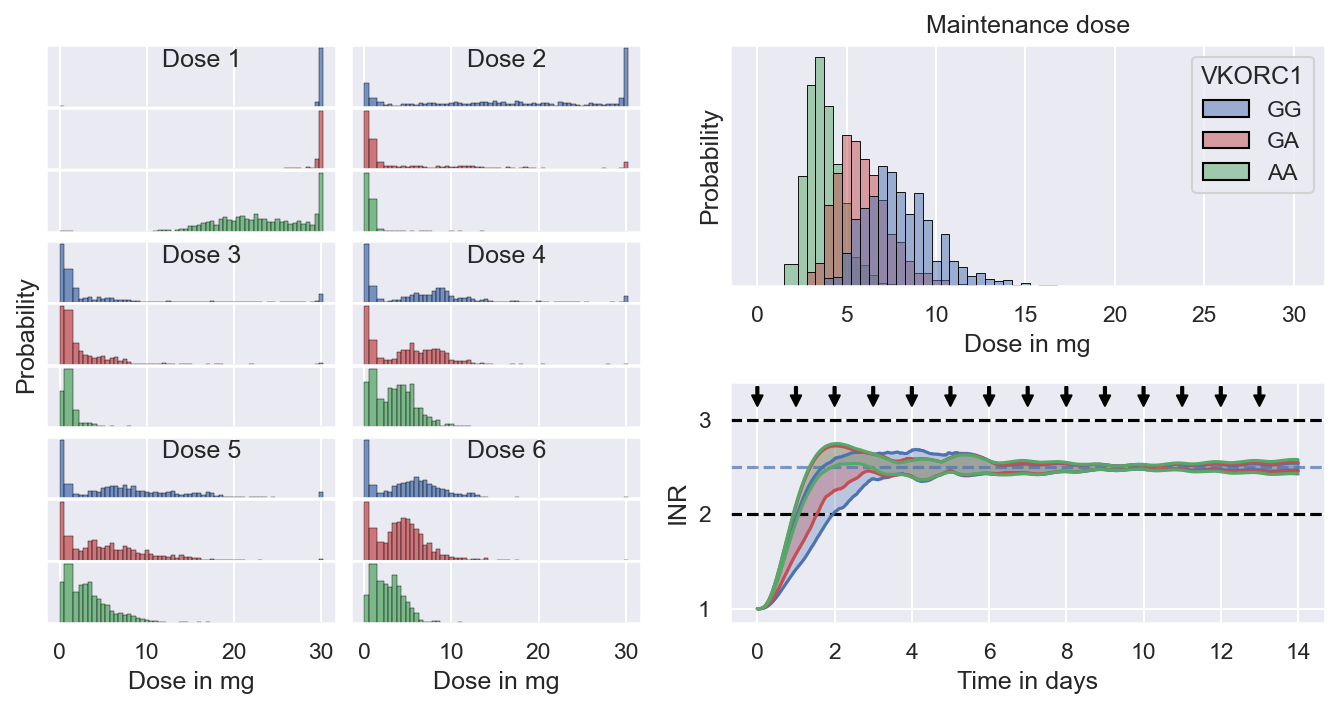

In [53]:
# Import parameters of individuals
directory = os.getcwd()
with open(
        directory
        + '/illustration_of_dosing_regimen_distribution_parameters.pickle',
        'rb') as f:
    psis = pickle.load(f)
    f.close()

# Import dosing regimens
days = 14
n_c, n_ids, _ = psis.shape
doses = np.empty(shape=(n_c, n_ids, days))
df = pd.read_csv(
    directory + '/illustration_of_dosing_regimen_distribution.csv')
for idc in range(n_c):
    temp = df[df.VKORC1 == idc]
    ids = np.sort(temp.ID.dropna().unique())
    for idx, _id in enumerate(ids):
        doses[idc, idx] = temp[temp.ID == _id][
            ['Dose %d in mg' % (day+1) for day in range(days)]].values[0]

# Predict response
duration = 0.01
times = np.linspace(0, days, num=1000) * 24
inrs = np.empty(shape=(n_c, n_ids, len(times)))
for idx, psi in enumerate(psis):
    for ids, sample in enumerate(psi):
        regimen = myokit.Protocol()
        for day, dr in enumerate(doses[idx, ids] / duration):
            if dr == 0:
                continue
            regimen.add(myokit.ProtocolEvent(
                level=dr,
                start=day*24,
                duration=duration))
        model.set_dosing_regimen(regimen)
        inrs[idx, ids] = model.simulate(parameters=sample, times=times)[1]

# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.15)

inner1 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=outer[0], hspace=0.05, wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[1], hspace=0.4, wspace=0)

innerinner1 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[0], hspace=0.01, wspace=0)
innerinner2 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[1], hspace=0.01, wspace=0)
innerinner3 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[2], hspace=0.01, wspace=0)
innerinner4 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[3], hspace=0.01, wspace=0)
innerinner5 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[4], hspace=0.01, wspace=0)
innerinner6 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=inner1[5], hspace=0.01, wspace=0)

# Create axes
axes = []
# axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, innerinner1[0]))
axes.append(plt.Subplot(fig, innerinner1[1]))
axes.append(plt.Subplot(fig, innerinner1[2]))
axes.append(plt.Subplot(fig, innerinner2[0]))
axes.append(plt.Subplot(fig, innerinner2[1]))
axes.append(plt.Subplot(fig, innerinner2[2]))
axes.append(plt.Subplot(fig, innerinner3[0]))
axes.append(plt.Subplot(fig, innerinner3[1]))
axes.append(plt.Subplot(fig, innerinner3[2]))
axes.append(plt.Subplot(fig, innerinner4[0]))
axes.append(plt.Subplot(fig, innerinner4[1]))
axes.append(plt.Subplot(fig, innerinner4[2]))
axes.append(plt.Subplot(fig, innerinner5[0]))
axes.append(plt.Subplot(fig, innerinner5[1]))
axes.append(plt.Subplot(fig, innerinner5[2]))
axes.append(plt.Subplot(fig, innerinner6[0]))
axes.append(plt.Subplot(fig, innerinner6[1]))
axes.append(plt.Subplot(fig, innerinner6[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes[:-3]):
    ax.sharex(axes[ida+1])

# Plot dose distributions
days = 7
covariates = ['GG'] * n_ids + ['GA'] * n_ids + ['AA'] * n_ids
colors = [
    sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2]]
for day in range(days-1):
    for idc, color in enumerate(colors):
        sns.histplot(
            x=doses[idc, :, day], ax=axes[day*len(colors)+idc],
            color=color, stat='probability', legend=False,
            bins=[
                0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
                6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75,
                11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
                15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75,
                20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25,
                24.75, 25.25, 25.75, 26.25, 26.75, 27.25, 27.75, 28.25, 28.75,
                29.25, 29.75, 30.25],
            edgecolor='black')
        axes[day*len(colors)+idc].set_yticks([])
        axes[day*len(colors)+idc].set_ylabel('')
df = pd.DataFrame({
    'Dose in mg': doses[:, :, 6].flatten(), 'VKORC1': covariates})
sns.histplot(
    df, x='Dose in mg', hue='VKORC1', ax=axes[18], multiple='layer',
    palette=colors, stat='probability', legend=True,
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25,
        5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75,
        11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
        15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75,
        20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25,
        24.75, 25.25, 25.75, 26.25, 26.75, 27.25, 27.75, 28.25, 28.75,
        29.25, 29.75, 30.25],
    edgecolor='black')

# Visualise therapeutic range
axes[19].axhline(y=2, color='black', linestyle='dashed')
axes[19].axhline(y=3, color='black', linestyle='dashed')

# Visualise target
axes[19].axhline(
    y=2.5, color=sns.color_palette()[0], linestyle='dashed', alpha=0.7)

# Plot INR
for idc, c in enumerate(colors):
    fifth_percentile = np.percentile(inrs[idc], q=5, axis=0)
    ninetyfifth_percentile = np.percentile(inrs[idc], q=95, axis=0)
    axes[19].plot(
        times / 24, fifth_percentile, color=c, label=labels[idc])
    axes[19].plot(
        times / 24, ninetyfifth_percentile, color=c)
    axes[19].fill_between(
        times / 24, fifth_percentile, ninetyfifth_percentile,
        color=c, alpha=0.3)

# Visualise dose points
days = 14
for day in range(days):
    axes[19].annotate(
        "", xy=(day, 3.15), xytext=(day, 3.35),
        arrowprops=dict(
            width=1, headwidth=5, headlength=5, color='black'))

# Labelling
axes[14].set_xlabel('Dose in mg')
axes[17].set_xlabel('Dose in mg')
axes[7].set_ylabel('Probability')
axes[18].set_title('Maintenance dose')
axes[18].set_yticks([])
axes[19].set_xlabel('Time in days')
axes[19].set_ylabel('INR')
axes[19].set_ylim([0.85, 3.4])

for ida, ax in enumerate([
        axes[0], axes[3], axes[6], axes[9], axes[12], axes[15]]):
    ax.annotate(
        "Dose %d" % (ida+1), xy=(0.4, 0.65), xytext=(0.4, 0.65),
        xycoords=ax.transAxes)

plt.savefig(
    '4_illustration_optimal_dosing_regimen_distribution.pdf',
    bbox_inches='tight')
plt.savefig(
    '4_illustration_optimal_dosing_regimen_distribution.tif',
    bbox_inches='tight')

plt.show()

## Illustrate Bayesian dosing regimen optimisation

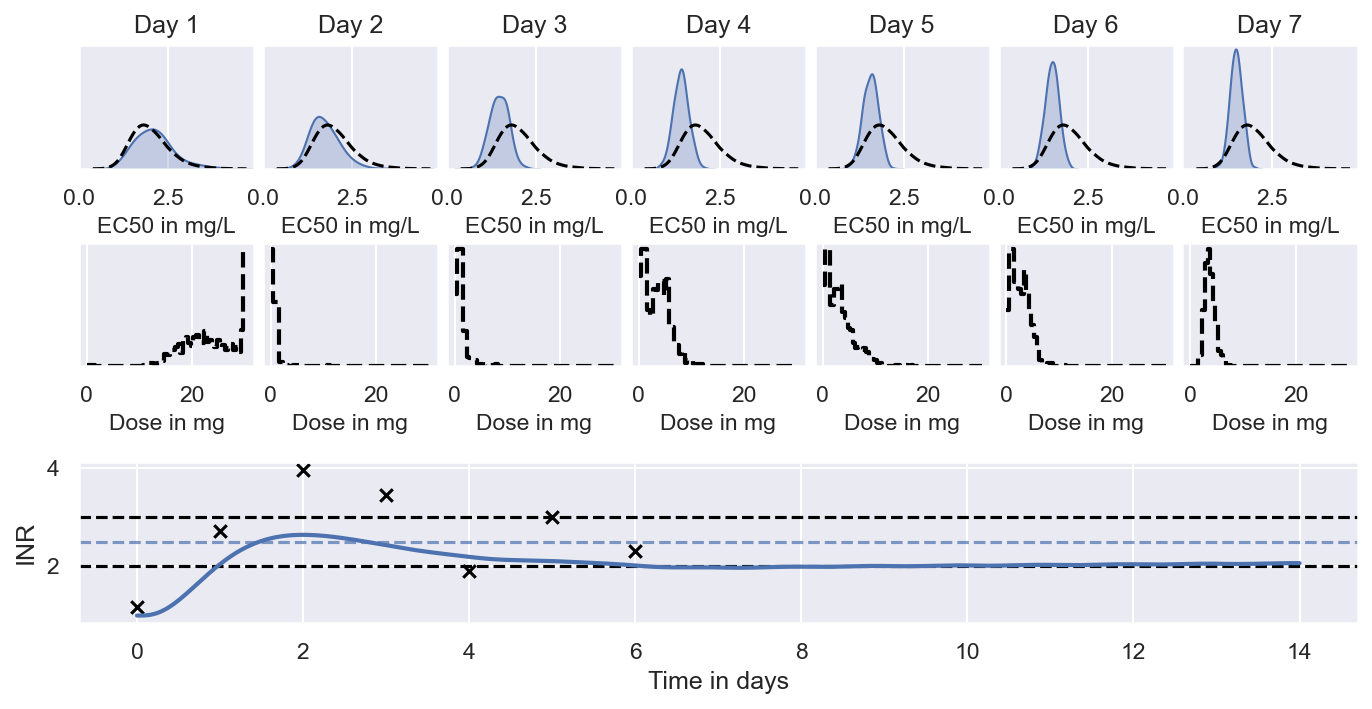

In [71]:
# Remember doses from abov
dose_prior = np.copy(doses[2])

# Import results
directory = os.getcwd()
df = pd.read_csv(
    directory + '/illustration_bayesian_dosing_regimen_optimisation.csv')

# Import parameters of individuals
directory = os.getcwd()
with open(
        directory
        + '/illustration_of_dosing_regimen_distribution_parameters.pickle',
        'rb') as f:
    psis = pickle.load(f)
    f.close()
_id = df.ID.unique()[0]
psi = psis[2, _id]

# Define model
model, _ = define_hamberg_model()

# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 1, hspace=0.4, height_ratios=[2, 1])

inner1 = gridspec.GridSpecFromSubplotSpec(
    2, 7, subplot_spec=outer[0], hspace=0.6, wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner1[4]))
axes.append(plt.Subplot(fig, inner1[5]))
axes.append(plt.Subplot(fig, inner1[6]))
axes.append(plt.Subplot(fig, inner1[7]))
axes.append(plt.Subplot(fig, inner1[8]))
axes.append(plt.Subplot(fig, inner1[9]))
axes.append(plt.Subplot(fig, inner1[10]))
axes.append(plt.Subplot(fig, inner1[11]))
axes.append(plt.Subplot(fig, inner1[12]))
axes.append(plt.Subplot(fig, inner1[13]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot EC50 posteriors and priors
# Visualise posteriors
days = 7
posteriors = np.empty(shape=(7, 2))
for day in range(days):
    n_obs = day + 1
    temp = df[df['Number of observations'] == n_obs]
    posteriors[day, 0] = temp['Mean'].values[0]
    posteriors[day, 1] = temp['Std.'].values[0]

# Sample from posteriors
seed = 1
n_samples = 1000
for ida, ax in enumerate(axes[:7]):
    if ida > 1:
        ec50 = np.random.normal(
            loc=posteriors[ida, 0], scale=posteriors[ida, 1], size=n_samples)
    else:
        ec50 = np.random.lognormal(
            mean=np.log(posteriors[ida, 0]),
            sigma=posteriors[ida, 1]/posteriors[ida, 0], size=n_samples)
    sns.kdeplot(
        ec50, ax=ax, fill=True, bw_adjust=1.5, label='Posterior')


# Visualise prior
# Define model
model, parameters_df = define_hamberg_model()
population_model = define_hamberg_population_model(conc=False)
pop_parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])

# Sample population (only EC50 varies for simplicity)
covariates = [0, 70, 2]
ec50 = population_model.sample(
    pop_parameters, covariates=covariates, seed=seed, n_samples=n_samples
    )[:, 1]
for ax in axes[:7]:
    sns.kdeplot(
        ec50, color='black', ax=ax, fill=False, bw_adjust=1.5,
        label='Prior', linestyle='--')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('EC50 in mg/L', fontsize=fontsize)
    ax.set_ylim([0, 2.25])
    ax.set_xlim([0, 4.9])

# Plot dose prior
for day in range(days):
    sns.histplot(
        x=dose_prior[:, day], ax=axes[day+7], fill=False, element='step',
        color='black', stat='probability', legend=False, linewidth=2,
        linestyle='--',
        bins=[
            0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
            6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75,
            11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
            15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75,
            20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25,
            24.75, 25.25, 25.75, 26.25, 26.75, 27.25, 27.75, 28.25, 28.75,
            29.25, 29.75, 30.25])
    axes[day+7].set_yticks([])
    axes[day+7].set_ylabel('')
    axes[day+7].set_xlabel('Dose in mg', fontsize=fontsize)

# Visualise true treatment response
days = 14
n_obs = np.max(df['Number of observations'].unique())
ds = df[df['Number of observations'] == n_obs][
    ['Dose %d in mg' % (day+1) for day in range(days)]].values[0]
duration = 0.01
times = np.linspace(0, days, num=1000) * 24
regimen = myokit.Protocol()
for day, dr in enumerate(ds / duration):
    if dr == 0:
        continue
    regimen.add(myokit.ProtocolEvent(
        level=dr,
        start=day*24,
        duration=duration))
model.set_dosing_regimen(regimen)
inr = model.simulate(parameters=sample, times=times)[1]

# Visualise therapeutic range
axes[-1].axhline(y=2, color='black', linestyle='dashed')
axes[-1].axhline(y=3, color='black', linestyle='dashed')

# Visualise target
axes[-1].axhline(
    y=2.5, color=sns.color_palette()[0], linestyle='dashed', alpha=0.7)

# Plot INR
axes[-1].plot(
    times / 24, inr, color=sns.color_palette()[0], linewidth=2)
axes[-1].set_xlabel('Time in days')
axes[-1].set_ylabel('INR')

# Plot INR measurements
n_obs = df['Number of observations'].unique()
meas = []
for n in n_obs:
    meas.append(df[df['Number of observations'] == n].INR.values[0])
axes[-1].scatter(
    n_obs-1, meas, color='black', marker='x')

# Label days
for ida, ax in enumerate(axes[:7]):
    ax.set_title("Day %d" % (ida+1))

plt.show()